# Demo with IPEX-XPU using DiT

### Stable Diffusion Pipeline:

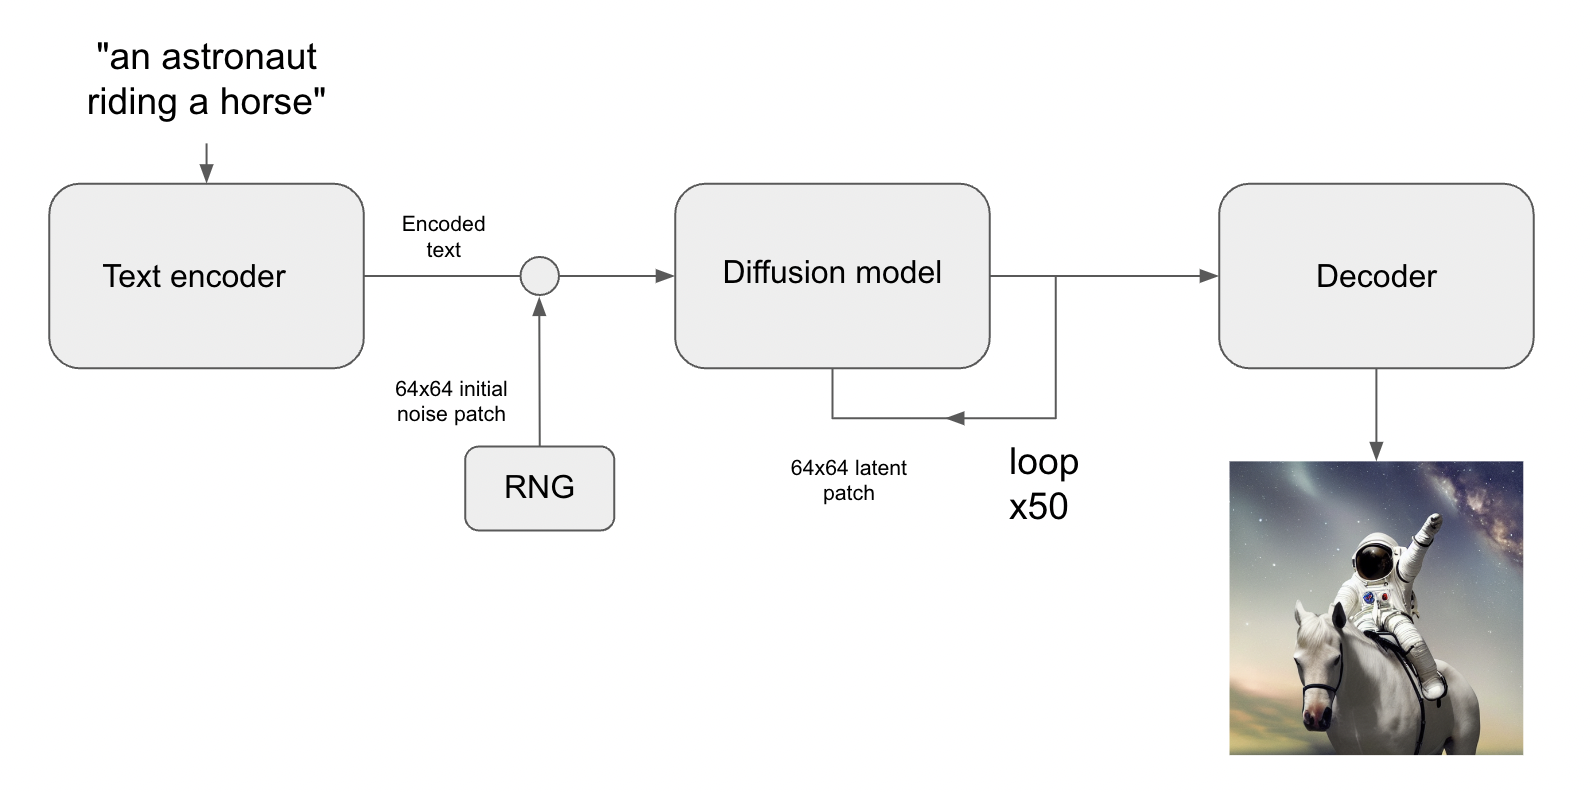

###### credits: https://keras.io/examples/generative/random_walks_with_stable_diffusion/ 

## Scalable Diffusion Models with Transformer (DiT)

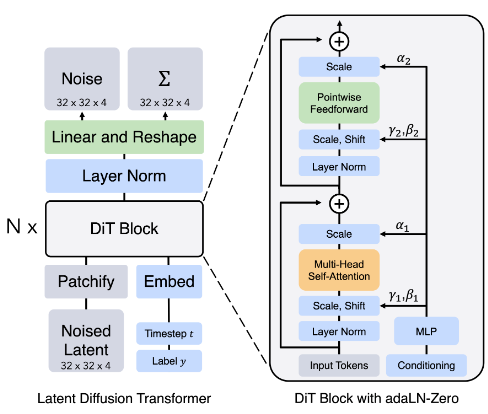

Replacing the U-Net backbone in latent diffusion models (LDMs) with a transformer. We call these models Diffusion Transformers, or DiTs for short.

## Demo with DiT using IPEX-XPU

This notebook samples from pre-trained DiT models. DiTs are class-conditional latent diffusion models trained on ImageNet that use transformers in place of U-Nets as the DDPM backbone. DiT outperforms all prior diffusion models on the ImageNet benchmarks.

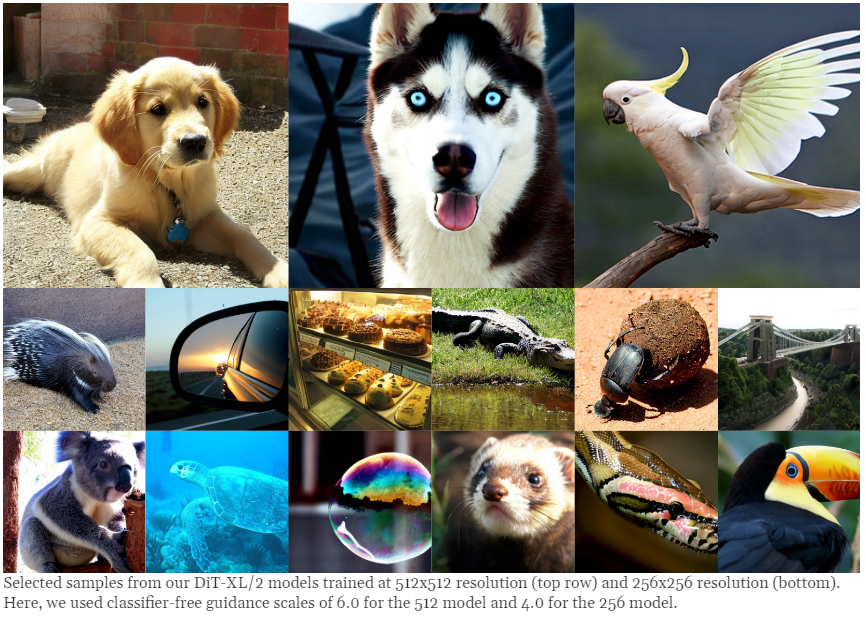
[Project Page](https://www.wpeebles.com/DiT) | [HuggingFace Space](https://huggingface.co/spaces/wpeebles/DiT) | [Paper](http://arxiv.org/abs/2212.09748) | [GitHub](github.com/facebookresearch/DiT)

#### Collect Hardware info

In [1]:
%cat /proc/cpuinfo | head -n 10

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 143
model name	: Intel(R) Xeon(R) Platinum 8480+
stepping	: 6
microcode	: 0x2b000081
cpu MHz		: 2000.000
cache size	: 107520 KB
physical id	: 0
cat: write error: Broken pipe


#### Collect Software info

In [2]:
import torch.utils.collect_env as environ

print(environ.main())


PyTorch version: 1.13.1
Is debug build: False
CUDA used to build PyTorch: None
ROCM used to build PyTorch: N/A

OS: Ubuntu 22.04.1 LTS (x86_64)
GCC version: (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
Clang version: Could not collect
CMake version: Could not collect
Libc version: glibc-2.35

Python version: 3.9.16 (main, Jan 11 2023, 16:05:54)  [GCC 11.2.0] (64-bit runtime)
Python platform: Linux-5.15.0-57-generic-x86_64-with-glibc2.35
Is CUDA available: False
CUDA runtime version: No CUDA
CUDA_MODULE_LOADING set to: N/A
GPU models and configuration: No CUDA
Nvidia driver version: No CUDA
cuDNN version: No CUDA
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

Versions of relevant libraries:
[pip3] intel-extension-for-pytorch==1.13.100
[pip3] numpy==1.23.5
[pip3] torch==1.13.1
[pip3] torchaudio==0.13.1
[pip3] torchvision==0.14.1
[conda] blas                      1.0                         mkl  
[conda] cpuonly                   2.0                           0 

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the DiT GitHub repo and setup PyTorch. You only have to run this once.

In [3]:
# !git clone https://github.com/facebookresearch/DiT.git
# import DiT, os
# os.chdir('DiT')
# os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
# !pip install diffusers timm --upgrade
# DiT imports:
import torch
import time
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")


GPU not found. Using CPU instead.


# Download DiT-XL/2 Models

You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

In [4]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

  0%|          | 0/2700611775 [00:00<?, ?it/s]

# 2. Sample from Pre-trained DiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

## Run with stock PyTorch

  0%|          | 0/10 [00:00<?, ?it/s]

time_taken 22.405366897583008


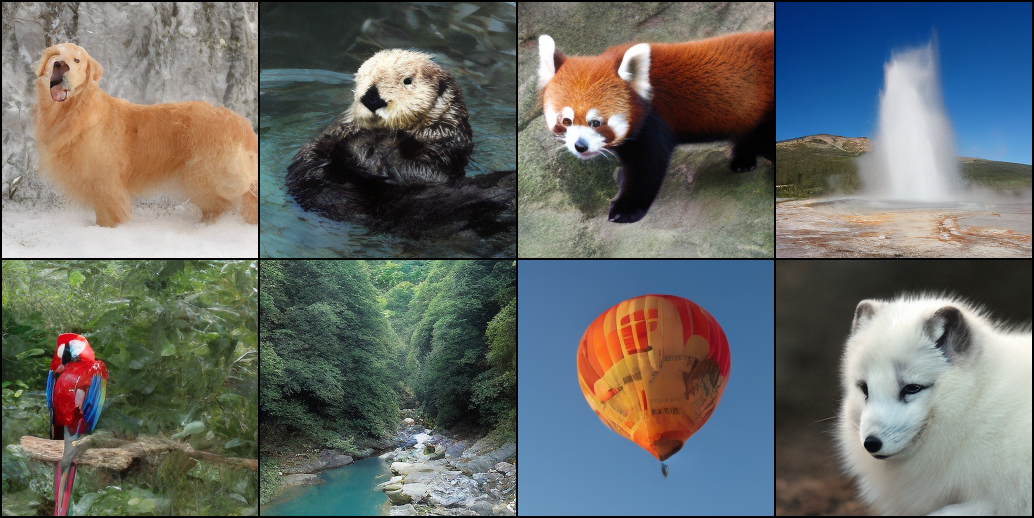

In [5]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 10 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

t1 = time.time()
# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
time_test = time.time() - t1
print("time_taken", time_test)

samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

## Run with IPEX-XPU

In [6]:
import intel_extension_for_pytorch as ipex
# device = "xpu"
device = "cpu"

# print(torch.xpu.device_count()); print(torch.xpu.get_device_properties(0));

In [12]:
#Load the Model

image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

# model = ipex.optimize(model, dtype=torch.bfloat16)
model = ipex.optimize(model)


  0%|          | 0/10 [00:00<?, ?it/s]

time_taken_ipex 10.306154727935791


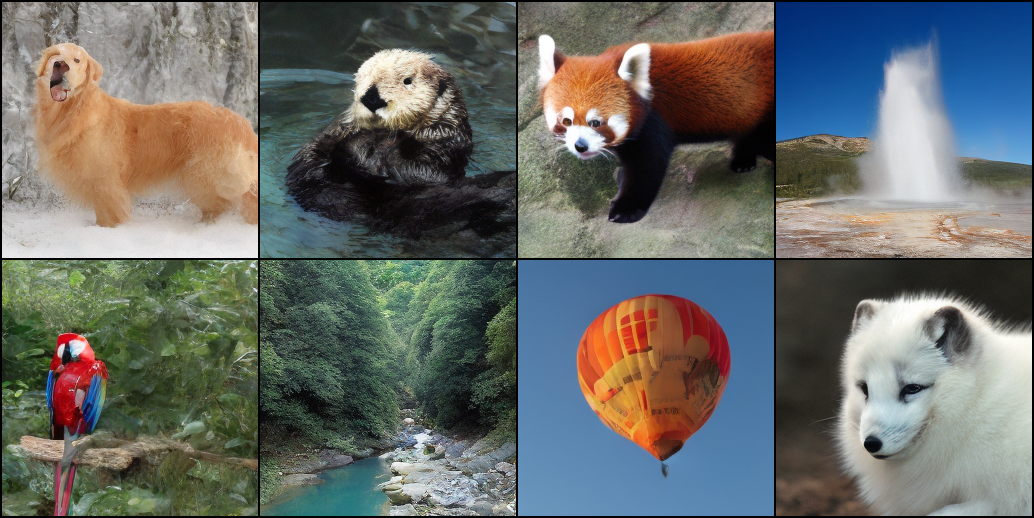

In [13]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 10 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

t1 = time.time()
# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
time_test_ipex = time.time() - t1
print("time_taken_ipex", time_test_ipex)

samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

## Performance Speedup

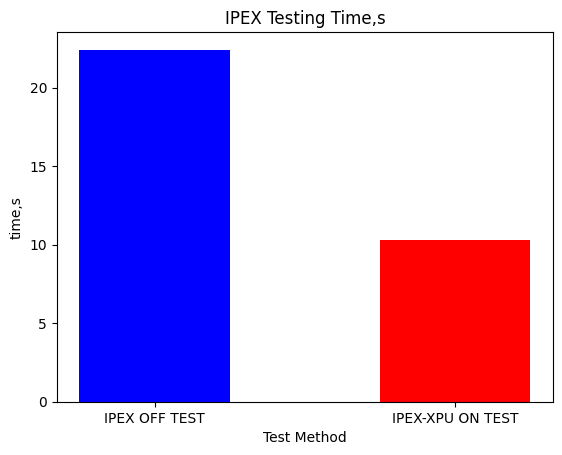

Performance Speedup Testing:  2.173979286071766
[CODE_SAMPLE_COMPLETED_SUCCESFULLY]


In [14]:
#show performance boost
import matplotlib.pyplot as plt

pred_times = [time_test, time_test_ipex]
tick_label = ['IPEX OFF TEST', 'IPEX-XPU ON TEST']

left = [1,2]
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'red'])
plt.xlabel('Test Method'); plt.ylabel('time,s'); plt.title('IPEX Testing Time,s')
plt.show()

# print("Performance Speedup Training: ",(time_train)/(time_train_ipex))
print("Performance Speedup Testing: ",(time_test)/(time_test_ipex))

print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')